# Model 3: Investigate fear generalization by measuring fear responses as a function of similarity to the CS+ or CTX+

In [1]:
import numpy as np
import nengo
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from uniform_encoders import *

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif')

In [54]:
class Inputs():
    def __init__(self, nCS=10, nCTX=1, dim_CS=2, dim_CTX=5, seed=0):
        self.rng = np.random.RandomState(seed=seed)
        self.sampler = ScatteredHypersphere(surface=True)
        self.dim_CS = dim_CS
        self.dim_CTX = dim_CTX
        self.nCS = nCS
        self.nCTX = nCTX
        self.CS = np.zeros((self.dim_CS))
        self.US = 0
        self.CTX = np.zeros((self.dim_CTX))
        self.CSs = self.sampler.sample(nCS, dim_CS, rng=self.rng)
        self.CTXs = self.sampler.sample(nCTX, dim_CTX, rng=self.rng)
        self.stop_learning = 0  # learning is active by default
    def get_CS(self, t):
        applied = True if t%2>1 else False  # 1s of no input, 1s of CS input
        return self.CS if applied else np.zeros((self.dim_CS))
    def get_CTX(self, t):
        return self.CTX
    def get_US(self, t):
        applied = True if t%2>1 else False # 1s of no input, 1s of US input 
        return self.US if applied else 0
    def get_stop_learning(self, t):
        return self.stop_learning

In [59]:
def build_network(
        seed = 0,
        lr = 3e-5,
        dt = 0.001,
        nCond = 5,
        nExt = 10,
        nNeurons = 100,
        dim_CS = 3,
        dim_CTX = 5,
        nCS = 1,
        nCTX = 3,
        intercept_CS = 0,
        intercept_CTX = 0,
        intercept_LA_pyr = -0.5,
        intercept_BLA_pyr = 0.0,
    ):

    rng = np.random.RandomState(seed=seed)
    sampler = ScatteredHypersphere(surface=True)
    inputs = Inputs(dim_CS=dim_CS, dim_CTX=dim_CTX, nCS=nCS, nCTX=nCTX, seed=seed)

    intercepts_pos = nengo.dists.Uniform(0,1)
    encoders_pos = nengo.dists.Choice([[1]])
    encoders_LA_pyr = sampler.sample(2*nNeurons, 2, rng=rng)
    encoders_BLA_pyr = sampler.sample(4*nNeurons, 4, rng=rng)
    intercepts_LA_pyr = nengo.dists.Uniform(intercept_LA_pyr, intercept_LA_pyr)
    intercepts_BLA_pyr = nengo.dists.Uniform(intercept_BLA_pyr, intercept_BLA_pyr)
    encoders_CS = sampler.sample(dim_CS*nNeurons, dim_CS, rng=rng)
    encoders_CTX = sampler.sample(dim_CTX*nNeurons, dim_CTX, rng=rng)
    intercepts_CS = nengo.dists.Uniform(intercept_CS, intercept_CS)
    intercepts_CTX = nengo.dists.Uniform(intercept_CTX, intercept_CTX)
    dInh = -3e0*np.ones((nNeurons, 1))
    
    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03

    with net:
        # inputs and outputs
        CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
        US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
        CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
        bias = nengo.Node(lambda t: 0.5)
        stop_learning = nengo.Node(lambda t, x: inputs.get_stop_learning(t), size_in=2)
        # external ensembles
        external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS, intercepts=intercepts_CS, encoders=encoders_CS)
        external_US = nengo.Ensemble(nNeurons, 1)
        external_CTX = nengo.Ensemble(dim_CTX*nNeurons, dim_CTX, intercepts=intercepts_CTX, encoders=encoders_CTX)
        # amygdala ensembles
        LA_pyr = nengo.Ensemble(2*nNeurons, 2, encoders=encoders_LA_pyr, intercepts=intercepts_LA_pyr)  # [CS, US]
        LA_inh = nengo.Ensemble(2*nNeurons, 2)  # [CS, US]
        CeL_on = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [CS]
        CeL_off = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [bias-CS]
        CeM = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        BLA_pyr = nengo.Ensemble(4*nNeurons, 4, radius=4, encoders=encoders_BLA_pyr, intercepts=intercepts_BLA_pyr)  # [CS, US, CTX]
        BLA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
        # error ensembles
        error_LA = nengo.Ensemble(nNeurons, 1)
        error_CeL = nengo.Ensemble(nNeurons, 1)
        error_BLA_safe = nengo.Ensemble(nNeurons, 1)
        error_BLA_fear = nengo.Ensemble(nNeurons, 1)
        # external connections
        nengo.Connection(CS, external_CS, synapse=None)
        nengo.Connection(US, external_US, synapse=None)
        nengo.Connection(external_CS, LA_inh[0], function=lambda x: np.sum(np.square(x)))  # any CS present
        nengo.Connection(external_US, LA_inh[1])
        nengo.Connection(external_US, LA_pyr[1])
        nengo.Connection(bias, CeL_off, transform=1)
        nengo.Connection(bias, CeM)
        nengo.Connection(CTX, external_CTX, synapse=None)
        # internal connections
        nengo.Connection(CeL_on, CeL_off, transform=-1)
        nengo.Connection(CeL_off, CeM, transform=-1)
        nengo.Connection(LA_pyr, BLA_pyr[:2])  # communicate [CS, US]
        nengo.Connection(BLA_pyr[:2], BLA_inh)  # communicate [CS,US]
        nengo.Connection(BLA_pyr[0], BLA_pyr[3], transform=0.25)  # CS response added to total fear response
        nengo.Connection(BLA_pyr[2], BLA_pyr[3], transform=0.75)  # CTX response added to total fear response
        nengo.Connection(BLA_pyr[3], CeM)  # communicate total fear response to CeM
        # learned connections
        conditioning = nengo.Connection(external_CS, LA_pyr[0], function=lambda x: 0, learning_rule_type=nengo.PES(lr))
        transmission = nengo.Connection(LA_pyr[0], CeL_on, function=lambda x: 0, learning_rule_type=nengo.PES(lr))
        extinction = nengo.Connection(external_CTX, BLA_pyr[2], function=lambda x: 0, learning_rule_type=nengo.PES(0.08*lr))
        # error connections
        nengo.Connection(LA_pyr, error_LA, function=lambda x: x[1]-x[0])  # US - CS response
        nengo.Connection(LA_pyr[0], error_CeL, transform=+1)  # LA_pyr CS response
        nengo.Connection(CeL_on, error_CeL, transform=-1)  # -CeL_on CS response
        nengo.Connection(BLA_pyr, error_BLA_safe, function=lambda x: x[0]+x[2])  # CS response + (-) CTX response
        nengo.Connection(BLA_pyr, error_BLA_fear, function=lambda x: x[1]-x[2])   # US response - CTX response
        # error gating
        nengo.Connection(LA_inh, error_LA.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
        nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: 1-x[0], transform=dInh)  # inhibit by default; release if CS
        nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: x[1], transform=10*dInh, synapse=1.0)  # inhibit if recent US
        nengo.Connection(BLA_inh, error_BLA_fear.neurons, function=lambda x: 1-1.2*x[1], transform=0.5*dInh)  # slow learning unless US
        # error updating
        nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
        nengo.Connection(error_CeL, transmission.learning_rule, transform=-1)
        nengo.Connection(error_BLA_safe, extinction.learning_rule, transform=1)
        nengo.Connection(error_BLA_fear, extinction.learning_rule, transform=-1)
        # prevent learning during testing
        nengo.Connection(stop_learning, error_LA.neurons, transform=dInh)
        nengo.Connection(stop_learning, error_CeL.neurons, transform=dInh)
        nengo.Connection(stop_learning, error_BLA_safe.neurons, transform=dInh)
        nengo.Connection(stop_learning, error_BLA_fear.neurons, transform=dInh)

        # probes
        net.pCS = nengo.Probe(CS, synapse=None)
        net.pUS = nengo.Probe(US, synapse=None)
        net.pCTX = nengo.Probe(CTX, synapse=None)
        net.pLA_pyr_spikes = nengo.Probe(LA_pyr.neurons)
        net.pLA_inh_spikes = nengo.Probe(LA_inh.neurons)
        net.pCeL_on_spikes = nengo.Probe(CeL_on.neurons)
        net.pCeL_off_spikes = nengo.Probe(CeL_off.neurons)
        net.pCeM_spikes = nengo.Probe(CeM.neurons)
        net.pBLA_pyr_spikes = nengo.Probe(BLA_pyr.neurons)
        net.pBLA_inh_spikes = nengo.Probe(BLA_inh.neurons)
        net.pBLA_pyr = nengo.Probe(BLA_pyr)
        net.pBLA_inh = nengo.Probe(BLA_inh)
        net.pLA_pyr = nengo.Probe(LA_pyr)
        net.pLA_inh = nengo.Probe(LA_inh)
        net.pCeL_on = nengo.Probe(CeL_on)
        net.pCeL_off = nengo.Probe(CeL_off)
        net.pCeM = nengo.Probe(CeM)
        net.pError_LA = nengo.Probe(error_LA)
        net.pError_CeL = nengo.Probe(error_CeL)
        net.pBLA_pyr = nengo.Probe(BLA_pyr)
        net.pBLA_inh = nengo.Probe(BLA_inh)
        net.pError_BLA_safe = nengo.Probe(error_BLA_safe)
        net.pError_BLA_fear = nengo.Probe(error_BLA_fear)
        
        # save pointers
        net.inputs = inputs
        net.LA_pyr = LA_pyr
        net.LA_inh = LA_inh
        net.CeL_on = CeL_on
        net.CeL_off = CeL_off
        net.CeM = CeM
        net.BLA_pyr = BLA_pyr
        net.BLA_inh = BLA_inh
        net.error_LA = error_LA
        net.error_CeL = error_CeL
        net.error_BLA_safe = error_BLA_safe
        net.error_BLA_fear = error_BLA_fear
        
    return net

## Experiment 1: Fear generalization to similar CS

In [62]:
def run_CS_generalization(
        seeds=5,
        nNeurons=100,
        learning_rate=3e-5,
        dt=1e-3,
        nCond=5,
        nExt=0,
        nCS=50,
        nCTX=1,
        dim_CS=3,
        dim_CTX=5,
        intercept_CS=0.5,
        intercept_CTX=0,
    ):

    data = pd.DataFrame(columns=["seed", "Fear Response", "Similarity to CS+"])
    rng = np.random.RandomState(seeds)

    for s in range(seeds):
        print(f"seed {s}")
        seed = s
        lr = rng.uniform(learning_rate/3, learning_rate*3)
        net = build_network(
            seed=seed, lr=lr, nNeurons=nNeurons, nCS=nCS, nCTX=nCTX,
            dim_CS=dim_CS, dim_CTX=dim_CTX, intercept_CS=intercept_CS, intercept_CTX=intercept_CTX)
        sim = nengo.Simulator(net, dt=dt, progress_bar=False)
        with sim:
            print("training")
            CSplus = net.inputs.CSs[0]
            net.inputs.CS = CSplus
            net.inputs.US = 1
            net.inputs.CTX = net.inputs.CTX[0]
            net.inputs.stop_learning = 0  # turn off learning for tests (inhibit all error populations)
            for p in range(nCond):
                sim.run(2)
            print("testing")
            net.inputs.stop_learning = 1  # turn off learning for tests (inhibit all error populations)
            net.inputs.US = 0
            for cs in range(nCS):
                print(f"CS {cs}")
                CS = net.inputs.CSs[cs]
                net.inputs.CS = CS
                sim.run(2)
                freezing = np.mean(sim.data[net.pCeM][-int(1/dt):])
                similarity = np.dot(CSplus, CS)
                data = data.append({
                    "seed": seed,
                    "Fear Response": freezing,
                    "Similarity to CS+": similarity
                }, ignore_index=True)

#         fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True,
#             figsize=((8,4)), gridspec_kw={'height_ratios': [1,1,4,2]})
#         axes[0].plot(sim.trange(), sim.data[net.pCeM])
#         axes[0].set(ylabel=r"$\hat{x}$", title="Fear Response", yticks=((0,1,2)))
#         axes[1].plot(sim.trange(), 1.0*np.linalg.norm(sim.data[net.pCS], ord=2, axis=1), label="CS present")
#         axes[1].plot(sim.trange(), 1.2*sim.data[net.pUS], label="US", c='r')
#         axes[1].set(yticks=((1.0, 1.2)), yticklabels=(("CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
#         axes[2].plot(sim.trange(), sim.data[net.pCeL_off], label="CeL_off")
#         axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,0], label="BLA_pyr_CS")
#         axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,2], label="BLA_pyr_CTX")
#         axes[2].legend()
#         axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
#         axes[3].plot(sim.trange(), sim.data[net.pError_LA], label="US minus CS (gated by LA_inh)")
#         axes[3].plot(sim.trange(), sim.data[net.pError_BLA_safe], label="CS minus CTX (gated by BLA_inh)")
#         axes[3].plot(sim.trange(), sim.data[net.pError_BLA_fear], label="US minus CTX (gated by BLA_inh)")
#         axes[3].legend()
#         axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
#         plt.tight_layout()

    data.to_pickle(f"CS_generalization_{intercept_CS}.pkl")
    
    for s in range(seeds):
        fig, ax = plt.subplots(figsize=((8,4)))
        sns.scatterplot(data=data.query("seed==@s"), x='Similarity to CS+', y="Fear Response", ax=ax)
        ax.set(title=f"Network Seed {s}")
        plt.tight_layout()
        fig.savefig(f"CS_generalization_seed{seed}.png")

seed 0
training
testing
CS 0
CS 1
CS 2
CS 3
CS 4
CS 5
CS 6
CS 7
CS 8
CS 9
CS 10
CS 11
CS 12
CS 13
CS 14
CS 15
CS 16
CS 17
CS 18
CS 19
CS 20
CS 21
CS 22
CS 23
CS 24
CS 25
CS 26
CS 27
CS 28
CS 29
CS 30
CS 31
CS 32
CS 33
CS 34
CS 35
CS 36
CS 37
CS 38
CS 39
CS 40
CS 41
CS 42
CS 43
CS 44
CS 45
CS 46
CS 47
CS 48
CS 49
CS 50
CS 51
CS 52
CS 53
CS 54
CS 55
CS 56
CS 57
CS 58
CS 59
CS 60
CS 61
CS 62
CS 63
CS 64
CS 65
CS 66
CS 67
CS 68
CS 69
CS 70
CS 71
CS 72
CS 73
CS 74
CS 75
CS 76
CS 77
CS 78
CS 79
CS 80
CS 81
CS 82
CS 83
CS 84
CS 85
CS 86
CS 87
CS 88
CS 89
CS 90
CS 91
CS 92
CS 93
CS 94
CS 95
CS 96
CS 97
CS 98
CS 99
CS 100
CS 101
CS 102
CS 103
CS 104
CS 105
CS 106
CS 107
CS 108
CS 109
CS 110
CS 111
CS 112
CS 113
CS 114
CS 115
CS 116
CS 117
CS 118
CS 119
CS 120
CS 121
CS 122
CS 123
CS 124
CS 125
CS 126
CS 127
CS 128
CS 129
CS 130
CS 131
CS 132
CS 133
CS 134
CS 135
CS 136
CS 137
CS 138
CS 139
CS 140
CS 141
CS 142
CS 143
CS 144
CS 145
CS 146
CS 147
CS 148
CS 149
CS 150
CS 151
CS 152
CS 153
CS 154
C

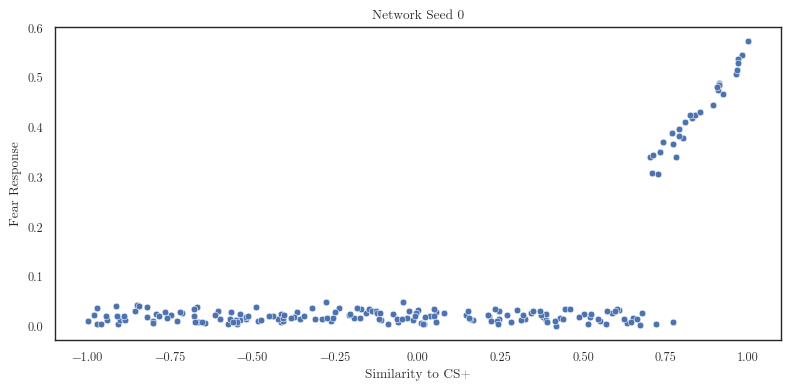

In [63]:
data = run_CS_generalization(seeds=1, nCS=200, intercept_CS=0.9)

In [ ]:
data = run_CS_generalization(seeds=1, nCS=200, intercept_CS=0.6)

seed 0
training
testing
seed 1
training
testing
seed 2
training
testing


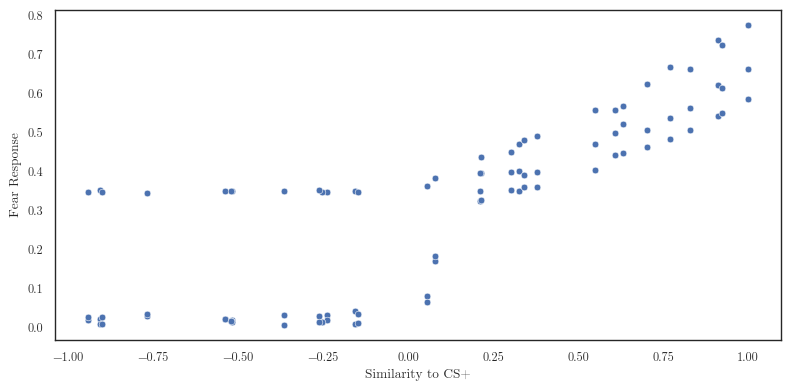

In [25]:
data = run_CS_generalization(seeds=1, nCS=200, intercept_CS=0.4)

## Experiment 2: Fear generalization to similar CTX

In [77]:
def run_CTX_generalization(
        seeds=5,
        nNeurons=100,
        learning_rate=3e-5,
        dt=1e-3,
        nCond=5,
        nExt=10,
        nCS=1,
        nCTX=10,
        dim_CS=3,
        dim_CTX=5,
        intercept_CS=0,
        intercept_CTX=0,
        experiment="ABX",
    ):

    data = pd.DataFrame(columns=["seed", "Fear Response", "Similarity to CTX+"])
    rng = np.random.RandomState(seeds)

    for s in range(seeds):
        print(f"seed {s}")
        seed = s
        lr = rng.uniform(learning_rate/3, learning_rate*3)
        net = build_network(
            seed=seed, lr=lr, nNeurons=nNeurons, nCS=nCS, nCTX=nCTX,
            dim_CS=dim_CS, dim_CTX=dim_CTX, intercept_CS=intercept_CS, intercept_CTX=intercept_CTX)
        sim = nengo.Simulator(net, dt=dt, progress_bar=False)
        with sim:
            print("conditioning")
            CTXplus = net.inputs.CTXs[0]
            net.inputs.CS = 0  # no CS stimuli for context learning
            net.inputs.US = 1
            net.inputs.CTX = CTXplus
            net.inputs.stop_learning = 0
            for p in range(nCond):
                sim.run(2)
            print("pause")
            net.inputs.pause = True
            net.inputs.CTX = np.zeros((dim_CTX))
            net.inputs.US = 0
            sim.run(4)
            net.inputs.pause = False  
            print("extinction")
            if experiment=="ABX":
                CTXminus = net.inputs.CTXs[1]
            elif experiment=="AAX":
                CTXminus = net.inputs.CTXs[0]
            net.inputs.CS = 0
            net.inputs.US = 0
            net.inputs.CTX = CTXminus
            net.inputs.stop_learning = 0
            for p in range(nExt):
                sim.run(2)
            print("testing")
            net.inputs.stop_learning = 1  # turn off learning for tests (inhibit all error populations)
            net.inputs.US = 0
            for ctx in range(nCTX):
                print(f"CTX {ctx}")
                CTX = net.inputs.CTXs[ctx]
                net.inputs.CTX = CTX
                net.inputs.CS = 0
                net.inputs.US = 0
                sim.run(2)
                freezing = np.mean(sim.data[net.pCeM][-int(1/dt):])
                similarity_plus = np.dot(CTXplus, CTX)
                similarity_minus = np.dot(CTXminus, CTX)
                data = data.append({
                    "seed": seed,
                    "Fear Response": freezing,
                    "Similarity to CTX+": similarity_plus,
                    "Similarity to CTX-": similarity_minus,
                }, ignore_index=True)

#         fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True,
#             figsize=((8,8)), gridspec_kw={'height_ratios': [2,4,4,2]})
#         axes[0].plot(sim.trange(), sim.data[net.pCeM])
#         axes[0].set(ylabel=r"$\hat{x}$", title="Fear Response", yticks=((0,1)))
#         ctx_plus_similarity = np.inner(CTXplus, sim.data[net.pCTX])
#         ctx_minus_similarity = np.inner(CTXminus, sim.data[net.pCTX])
#         axes[1].plot(sim.trange(), 1.3*np.linalg.norm(sim.data[net.pCS], ord=2, axis=1), label="CS present")
#         axes[1].plot(sim.trange(), 1.5*sim.data[net.pUS], label="US", c='r')
#         axes[1].plot(sim.trange(), ctx_plus_similarity, label="CTX similarity to CTX_A")
#         axes[1].plot(sim.trange(), ctx_minus_similarity, label="CTX similarity to CTX_B")
#         axes[1].legend()
#         axes[1].set(yticks=((1.0, 1.2)), yticklabels=(("CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
#         axes[2].plot(sim.trange(), sim.data[net.pCeL_off], label="CeL_off")
#         axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,0], label="BLA_pyr_CS")
#         axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,2], label="BLA_pyr_CTX")
#         axes[2].legend()
#         axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
#         axes[3].plot(sim.trange(), sim.data[net.pError_LA], label="US minus CS (gated by LA_inh)")
#         axes[3].plot(sim.trange(), sim.data[net.pError_BLA_safe], label="CS minus CTX (gated by BLA_inh)")
#         axes[3].plot(sim.trange(), sim.data[net.pError_BLA_fear], label="US minus CTX (gated by BLA_inh)")
#         axes[3].legend()
#         axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
#         plt.tight_layout()

    data.to_pickle(f"CTX_generalization_{experiment}.pkl")

    for s in range(seeds):
        if experiment=="ABX":
            fig, ax = plt.subplots(figsize=((8,4)))
            sns.scatterplot(data=data.query("seed==@s"), x='Similarity to CTX+', y="Similarity to CTX-",
                hue="Fear Response", size="Fear Response", palette="viridis", ax=ax)
            ax.set(xlim=((-1.1,1.1)), ylim=((-1.1,1.1)), title=f"Network Seed {s}")
            plt.tight_layout()
            fig.savefig(f"CTX_generalization_ABX_seed{s}.png")

        elif experiment=="AAX":
            fig, ax = plt.subplots(figsize=((8,4)))
            sns.scatterplot(data=data.query("seed==@s"), x='Similarity to CTX+', y="Fear Response", ax=ax)
            ax.set(xlim=((-1.1,1.1)), xlabel="Similarity to CTX A", title=f"Network Seed {s}")
            plt.tight_layout()
            fig.savefig(f"CTX_generalization_ABX_seed{s}.png")

    return data

### 2.1 ABX testing
Train CTX-US association in CTX A, then do extinction training with no US in CTX B. Test CTX-induced freezing in many CTX X, with variable similarity to CTX A and CTX B.

seed 0
conditioning
pause
extinction
testing
CTX 0
CTX 1
CTX 2
CTX 3
CTX 4
CTX 5
CTX 6
CTX 7
CTX 8
CTX 9
CTX 10
CTX 11
CTX 12
CTX 13
CTX 14
CTX 15
CTX 16
CTX 17
CTX 18
CTX 19
CTX 20
CTX 21
CTX 22
CTX 23
CTX 24
CTX 25
CTX 26
CTX 27
CTX 28
CTX 29
CTX 30
CTX 31
CTX 32
CTX 33
CTX 34
CTX 35
CTX 36
CTX 37
CTX 38
CTX 39
CTX 40
CTX 41
CTX 42
CTX 43
CTX 44
CTX 45
CTX 46
CTX 47
CTX 48
CTX 49
CTX 50
CTX 51
CTX 52
CTX 53
CTX 54
CTX 55
CTX 56
CTX 57
CTX 58
CTX 59
CTX 60
CTX 61
CTX 62
CTX 63
CTX 64
CTX 65
CTX 66
CTX 67
CTX 68
CTX 69
CTX 70
CTX 71
CTX 72
CTX 73
CTX 74
CTX 75
CTX 76
CTX 77
CTX 78
CTX 79
CTX 80
CTX 81
CTX 82
CTX 83
CTX 84
CTX 85
CTX 86
CTX 87
CTX 88
CTX 89
CTX 90
CTX 91
CTX 92
CTX 93
CTX 94
CTX 95
CTX 96
CTX 97
CTX 98
CTX 99


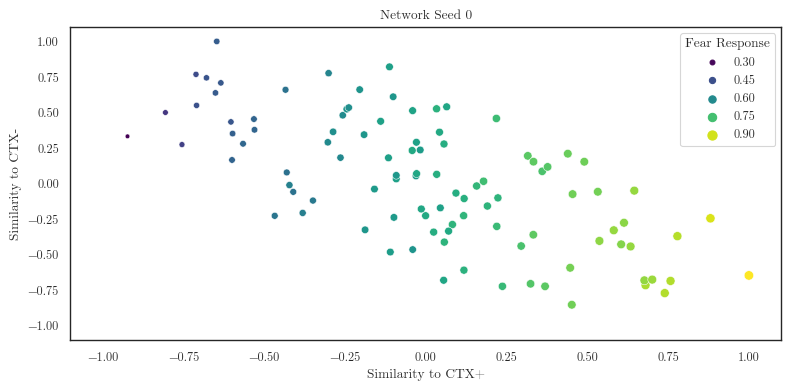

In [78]:
data = run_CTX_generalization(seeds=1, nCTX=100, experiment="ABX", intercept_CTX=0.0)

In [ ]:
data = run_CTX_generalization(seeds=1, nCTX=100, experiment="ABX", intercept_CTX=0.6)

seed 0
conditioning


### 2.2 AAX testing
Train CTX-US association in CTX A, then do extinction training with no US also in CTX A. Test CTX-induced freezing in many CTX X, with variable similarity to CTX A.

In [ ]:
data = run_CTX_generalization(seeds=1, nCTX=100, experiment="AAX")

In [ ]:
data = run_CTX_generalization(seeds=1, nCTX=100, experiment="AAX", intercept_CTX=0.6)